# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [57]:
import numpy as np
import functions as fn
import seismic_model as sm
import optimizer as opt
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import importlib

***
#### Synthetic parameters
***

Original params:  [ 266.35092347   57.96081756 -163.18574684]


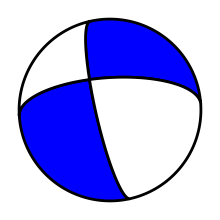

In [58]:
np.random.seed(2024)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

***
#### Hybrid inversion
***

In [59]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
velocities = np.array([5.8000, 3.4600])
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)
Ao = inv_model.get_Ao()

# tune hyperparameters
config = opt.get_config()
config['alpha'] = 5e-2
config['c_decrease'] = 1e-4
config['k_max'] = 3000
config['tolerance'] = 1e-5
config['print_every'] = 0

# # initialize random hybrid search
# num_runs = 100
# starts = fn.random_params(num_runs)

# initialize systematic hybrid search
step_size = 30
starts = fn.systematic_params(step_size)
num_runs = len(starts)

# multi-start optimization
convergence_count = 0
best_params = []
best_misfits = []
inv_model.reset()
print_every = 20

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index+1}/{num_runs}')
    params, misfit, converged = opt.minimize(inv_model, config, start)
    if converged:
        convergence_count += 1
        best_params.append(params)
        best_misfits.append(misfit)

print(f'Convergence rate: {100*convergence_count/num_runs:.0f}%')    

Run 1/102
Run 21/102
Run 41/102
Run 61/102
Run 81/102
Run 101/102
Convergence rate: 94%


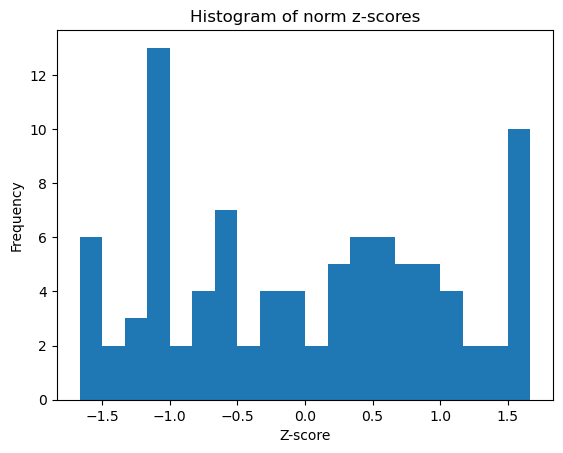

In [60]:
# insert code to filter out outliers
inv_model.filter_outliers()

# inv_model.get_optimal_amplitudes()
norms = [np.linalg.norm(p) for p in inv_model.get_optimal_amplitudes()]
av_norm, st_dev = np.mean(norms), np.std(norms)
z_scores = [(norm - av_norm) / st_dev for norm in norms]

# histogram of z-scores
plt.hist(z_scores, bins=20)
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Histogram of norm z-scores')
plt.show()

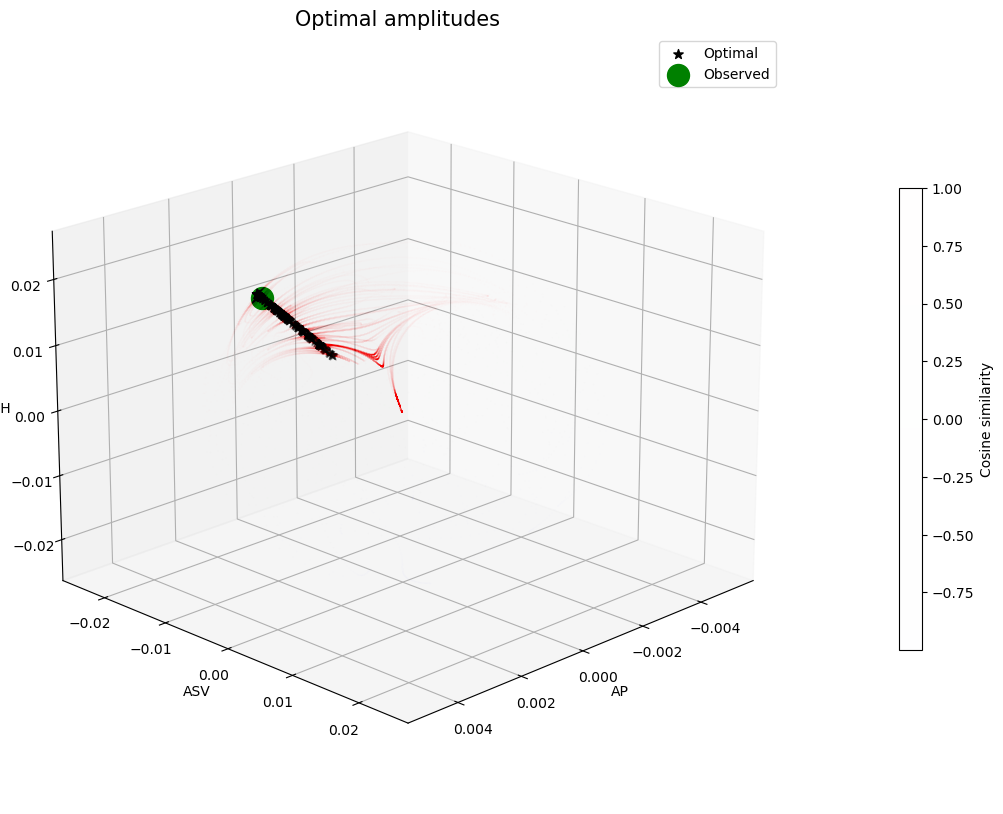

In [61]:
# plot amplitudes
inv_model.plot_amplitudes(azim=45, elev=20, s=50, alpha=0.005, iterates=True)

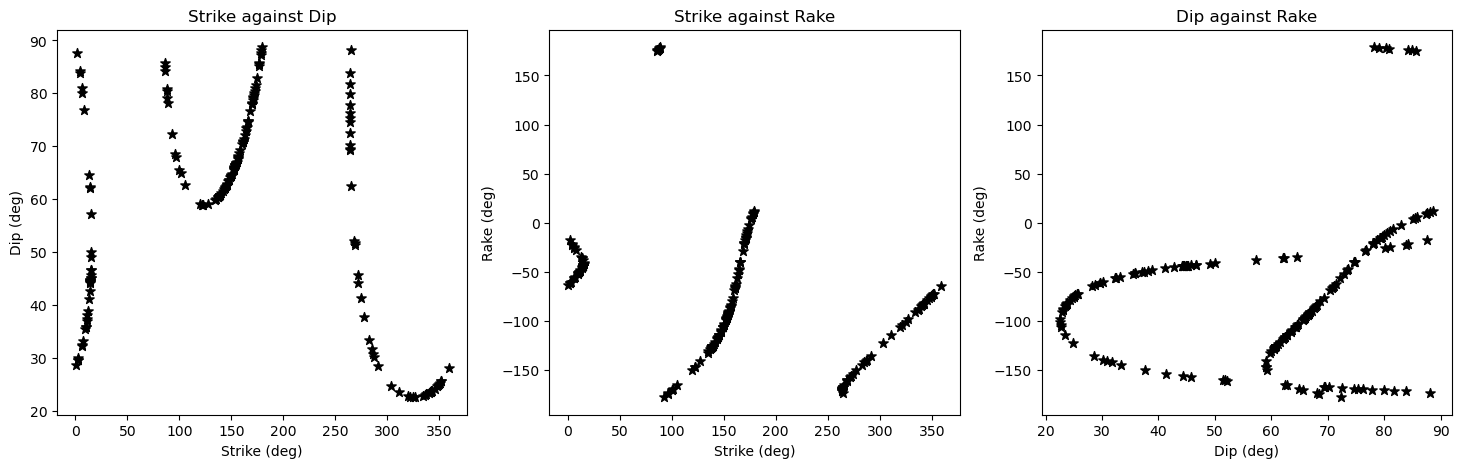

In [63]:
# iterate plot - sdr space
inv_model.plot_iterates_2D(cmap='rainbow', s=1, optimal=True, index=2)
# inv_model.plot_iterates_2D(cmap='rainbow', s=1, optimal=False, index=0)
# inv_model.plot_iterates_2D(cmap='rainbow', s=1, optimal=False, index=1)

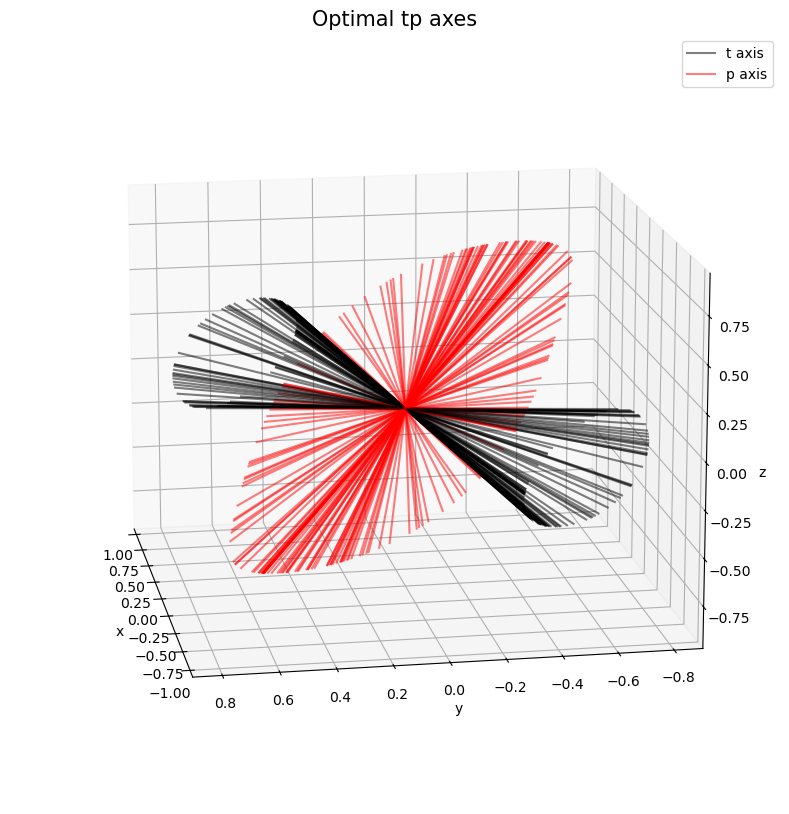

In [64]:
# tp axes - full
inv_model.plot_tp_axes(azim=170, elev=15, half=False)

#### Insights:

* We're forming cones in tp space whose central angles we can either calculate or estimate.

* What does this have to do with the ray path/exit angle?

* Perform a multilinear regression on the narrow cone! You can find the narrow cone.

***
#### Output beachballs
***

Check for the signs (using seed 2024, start = zeros, ones)

Test with 5 starting points

Check for auxiliary beachballs/mirror images

Verify the amplitude vectors for comparison with original

Space should be flat close to 1

Work on convergence of SD

Sliced contour maps (from true params)

Endpoint amplitudes (look for clusters)

In [ ]:
# # TODO: Omkar's code for combined beachball plots
# for param in best_params:
#     beachball = fn.beachball(np.rad2deg(fn.bound(param)))
#     pass

# fn.plot_beachball_set(best_params)

***
#### Kagan angle distribution
***

In [ ]:
# TODO: Generate a distribution of Kagan angles compared to true parameters
# Aim: collapse beachball distributions to 1 dimension, investigate modality
# Nseko's code for Kagan angles (from paper)

# kagan_angles = [fn.kagan_angle(true_params, p) for p in best_params]
# plt.hist(kagan_angles, bins=20)

In [ ]:
# TODO: Fix the gradient